In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
from arsenal import colors
from bench.spider.interface import SpiderInterface
from IPython.display import HTML
from genparse import EOS

import nest_asyncio

nest_asyncio.apply()

In [3]:
spider = SpiderInterface()

In [4]:
# for x in spider.dev_data[:2]:
#    print()
#    print(x.text)
#    print(x.gold_sql)
#    print(x.db_name)

In [9]:
x = spider.dev_data[0]
assert x.evaluate(x.gold_sql)
x

<SpiderExample db='concert_singer', text='How many singers do we have?'>

In [13]:
x = spider.dev_data[1]
assert x.evaluate('SELECT count(*) FROM singer')
x

<SpiderExample db='concert_singer', text='What is the total number of singers?'>

In [14]:
x.run_query('SELECT count(*) FROM singer')

,count(*)
0,6


In [16]:
from pathlib import Path

import bench.spider.evaluation as E
from bench.spider.evaluation import (
    # build_foreign_key_map_from_json,
    build_valid_col_units,
    rebuild_sql_val,
    rebuild_sql_col,
    eval_exec_match,
)


def evaluate(self, gold: str, pred: str, db_name: str):
    """Returns: bool, Optional[str]

    On success (i.e., predicted execution result is the same as gold), returns `(True, None)`
    On failure, returns `(False, reason)` where reason is one of the two cases:
    * `invalid` if `pred` sql is not a well-formed sql statement that can be parsed by sqlite
    * `mismatch` if `pred` is a well-formed sql but the execution result is different from that of the `gold`.
    """
    db = self.db_path / db_name / (db_name + '.sqlite')
    schema = E.Schema(E.get_schema(db))
    g_sql = E.get_sql(schema, gold)

    try:
        p_sql = E.get_sql(schema, pred)
    except Exception as e:
        # sql is ill-formed (can't be parsed by sqlite engine)
        print(
            colors.red % e.__class__.__name__,
            e,
        )

        import traceback

        traceback.print_exc()

        return False, 'invalid'

    kmap = self.kmaps[db_name]
    g_valid_col_units = build_valid_col_units(g_sql['from']['table_units'], schema)
    g_sql = rebuild_sql_val(g_sql)
    g_sql = rebuild_sql_col(g_valid_col_units, g_sql, kmap)
    p_valid_col_units = build_valid_col_units(p_sql['from']['table_units'], schema)
    p_sql = rebuild_sql_val(p_sql)
    p_sql = rebuild_sql_col(p_valid_col_units, p_sql, kmap)

    exec_match = eval_exec_match(db, pred, gold, p_sql, g_sql)
    reason = None if exec_match else 'mismatch'

    return exec_match, reason


# spider.evaluator = evaluate

In [17]:
# x.interface.evaluator = evaluate

In [18]:
x.interface.evaluator.evaluate = evaluate

In [21]:
junk_sql = 'select count(*) from sangerz'

In [22]:
x.interface.evaluator.evaluate(
    x.interface.evaluator, gold=x.gold_sql, pred=junk_sql, db_name=x.db_name
)

KeyError 'sangerz'


Traceback (most recent call last):
  File "/home/timv/tmp/ipykernel_5039/1033643670.py", line 25, in evaluate
    p_sql = E.get_sql(schema, pred)
  File "/home/timv/projects/genparse/bench/spider/process_sql.py", line 618, in get_sql
    _, sql = parse_sql(toks, 0, tables_with_alias, schema)
  File "/home/timv/projects/genparse/bench/spider/process_sql.py", line 562, in parse_sql
    from_end_idx, table_units, conds, default_tables = parse_from(
  File "/home/timv/projects/genparse/bench/spider/process_sql.py", line 439, in parse_from
    idx, table_unit, table_name = parse_table_unit(
  File "/home/timv/projects/genparse/bench/spider/process_sql.py", line 289, in parse_table_unit
    key = tables_with_alias[toks[idx]]
KeyError: 'sangerz'


(False, 'invalid')

In [23]:
# x.db_schema.columns

In [24]:
grammar_text = open(
    '/home/timv/projects/genparse/benchmark/grammars/sql_case_insensitive.lark'
).read()

In [25]:
from genparse.util import InferenceSetupVLLM, InferenceSetup

In [26]:
# infer = InferenceSetup('codellama', grammar_text, proposal_name='character', guide_opts={'ignore': '\s*'})
infer = InferenceSetupVLLM(
    'codellama',
    grammar_text,
    proposal_name='character',
    guide_opts={'ignore': r'\s*'},
    batch_size=50,
)

INFO 06-28 18:46:49 config.py:1214] Upcasting torch.bfloat16 to torch.float32.
INFO 06-28 18:46:49 llm_engine.py:161] Initializing an LLM engine (v0.5.0.post1) with config: model='codellama/CodeLlama-7b-Instruct-hf', speculative_config=None, tokenizer='codellama/CodeLlama-7b-Instruct-hf', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, rope_scaling=None, rope_theta=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float32, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto, quantization_param_path=None, device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='outlines'), seed=0, served_model_name=codellama/CodeLlama-7b-Instruct-hf)
INFO 06-28 18:46:50 selector.py:136] Cannot use FlashAttention-2 backend for dtype other than torch.float16 or torch.bfloat16.
INFO 06-28 18:46:50 selector.py:51] Using XFormer

In [93]:
x = spider.dev_data[2]
x

<SpiderExample db='concert_singer', text='Show name, country, age for all singers ordered by age from the oldest to the youngest.'>

In [128]:
infer.sampler.timer.compare()

llm is 45.2331x faster than cfg+trie (p=0.00000, median: cfg+trie: 1.57952, llm: 0.0349195)


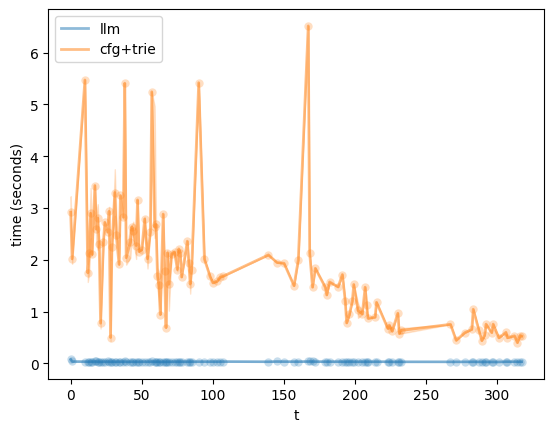

In [127]:
infer.sampler.timer.plot_feature('t')

In [97]:
p = infer(x.describe(), n_particles=50, method='smc-standard', max_tokens=100)

In [98]:
def show_posterior_tables(x, p):
    display(HTML(f'<h3>{x.text}</h3>'))
    for y, py in sorted(p[0].posterior.items(), key=lambda ab: -ab[1]):
        y = y[:-1]  # remove EOS
        print(f'{colors.mark(x.evaluate(y))} {py:-.6f} {y}')
        try:
            display(x.run_query(y))
        except Exception as e:
            print()
            print(colors.dark.red % '💀 ERROR', e)
            print()

In [99]:
show_posterior_tables(x, p)

✘ 0.324854 Select singer_name, singer_country, singer_age from singer_in_concert inner join singer on singer_in_concert.singer_id = singer.singer_id

💀 ERROR Execution failed on sql 'Select singer_name, singer_country, singer_age from singer_in_concert inner join singer on singer_in_concert.singer_id = singer.singer_id': no such column: singer_name

✘ 0.243641 Select singer_name from singer inner join concert on concert_ID = concert.singer_ID

💀 ERROR Execution failed on sql 'Select singer_name from singer inner join concert on concert_ID = concert.singer_ID': no such column: singer_name

✘ 0.081214 Select singer.Song_name, singer.Name, singer.Country, singer.Song_release_year from singer inner join concert_attendees on singer.Singer_ID = concert_attendees.Singer_ID order by singer.Age 

💀 ERROR Execution failed on sql 'Select singer.Song_name, singer.Name, singer.Country, singer.Song_release_year from singer inner join concert_attendees on singer.Singer_ID = concert_attendees.Singer_I

### Approximate Minimum Bayes Risk Decoding

In [100]:
x.gold_sql

'SELECT name ,  country ,  age FROM singer ORDER BY age DESC'

In [111]:
print(x.describe())


You are a coding assistant helping an analyst answer questions over business data in SQL.
More specifically, the analyst provides you a database schema
(tables in the database along with their column names and types)
and asks a question about the data that can be solved by issuing a SQL query to the database.
In response, you write the SQL statement that answers the question.
You do not provide any commentary or explanation of what the code does,
just the SQL statement ending in a semicolon.

Here is a database schema:

stadium
* Stadium_ID (number): stadium id
* Location (text): location
* Name (text): name
* Capacity (number): capacity
* Highest (number): highest
* Lowest (number): lowest
* Average (number): average

singer
* Singer_ID (number): singer id
* Name (text): name
* Country (text): country
* Song_Name (text): song name
* Song_release_year (text): song release year
* Age (number): age
* Is_male (others): is male

concert
* concert_ID (number): concert id
* concert_Name (te

In [101]:
def EVAL(x, y1, y2):
    if y1.endswith(EOS):
        y1 = y1[:-1]
    if y2.endswith(EOS):
        y2 = y2[:-1]
    try:
        return x.interface.evaluate(y1, y2, x.db_name)[0]
    except Exception:
        #        print(e)
        return False

In [102]:
def risk(x, candidate, particles):
    return sum(p * EVAL(x, candidate, y) for y, p in particles[0].posterior.items())

In [108]:
def show_mbr_tables(x, particles):
    display(HTML(f'<h3>{x.text}</h3>'))
    risks = {
        candidate: risk(x, candidate, particles) for candidate in particles[0].posterior
    }
    for candidate in sorted(risks, key=risks.__getitem__, reverse=True):
        print(
            colors.mark(
                x.evaluate(candidate[:-1] if candidate.endswith(EOS) else candidate)
            ),
            f'{risks[candidate]:f}',
            (colors.dark.magenta if risks[candidate] == 0 else colors.light.magenta)
            % candidate,
        )
        try:
            display(x.run_query(candidate[:-1] if candidate.endswith(EOS) else candidate))
        except Exception as e:
            print()
            print(colors.dark.red % '💀 ERROR', e)
            print()

In [109]:
show_mbr_tables(x, p)

✘ 0.000000 Select singer.Song_name, singer.Name, singer.Country, singer.Song_release_year from singer inner join concert_attendees on singer.singer_id = concert_attendees.singer_id inner join concert on concert_attendees.concert_id = concert.concert_id Where ships.ships = '737' and spacecraft.planet='Earth' and crew.ships = '73

💀 ERROR Execution failed on sql 'Select singer.Song_name, singer.Name, singer.Country, singer.Song_release_year from singer inner join concert_attendees on singer.singer_id = concert_attendees.singer_id inner join concert on concert_attendees.concert_id = concert.concert_id Where ships.ships = '737' and spacecraft.planet='Earth' and crew.ships = '73': unrecognized token: "'73"

✘ 0.000000 Select singer_name from singer inner join concert on concert_ID = concert.singer_ID▪

💀 ERROR Execution failed on sql 'Select singer_name from singer inner join concert on concert_ID = concert.singer_ID': no such column: singer_name

✘ 0.000000 Select singer_name, singer_count